In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier


path="dataset.csv"

## DATA CLEANING

To detect automatically the delimiter or separator, it is specified that separator is equal to None to make python find it. See the explanation of sep parameter on:
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
dataset=pd.read_csv(path, sep=None, engine="python")

In [ ]:
dataset.head()

Balance in the objective variable:

In [ ]:
dataset['churn'].value_counts()

In [ ]:
sns.countplot(x='churn', data=dataset, palette='hls')
plt.show()

Now, It is necessary to analyse if there is any NaN value. For see the number of NaN values for each attribute is necessary to extend the maximum number of rows that pandas let to show. It is used "with" to do it only for this code block.

In [ ]:
print("Dataset size:", dataset.shape)

#Modifying the maximum number of rows that pandas let to show
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
   print(dataset.isnull().sum())

### DROPS

Attributes dropped:
- ethnic: is not ethical to keep this attribute
- numbcars: almost half of the dataset doesn't have this attribute
- Customer_ID: it has not variance because is unique for each customer
- ownrent, lor, dwlltype, HHstatin, dwllsize: They are NaN on 30% of the dataset

In [ ]:
datasetClean=dataset.drop(columns=["ethnic", "numbcars", "Customer_ID", "ownrent", "lor", "dwlltype", "HHstatin", "dwllsize"])
print("Dataset size:", datasetClean.shape)

In order to code categorical attributes, object attributes need to be transform.

In [ ]:
datasetClean.dtypes

In [ ]:
datasetClean.select_dtypes(include='object').columns

Object attributes which are numbers with "," are pass to floats and object with only numbers and more than 2 different numbers are convert to integer.

In [ ]:
objectAttributesList = datasetClean.select_dtypes(include='object').columns
#print(objectAttributesList)
for column in objectAttributesList:
   # Looking through all the column to see if there are one string with a number

   if datasetClean[column].str.contains('\d,').any():
      # Casting column from string with "," to float with "."
      datasetClean[column] = datasetClean[column].str.replace(',', '.').astype(float)

   elif datasetClean[column].str.contains('\d+').all() and len(datasetClean[column].unique()) > 2:
      #If the values in the column are numbers and there are not binary, they are not categorical
      datasetClean[column] = datasetClean[column].astype(int)

Now, only remains attributes which are categorical, binaries and labels

In [ ]:
datasetClean.select_dtypes(include='object').columns

A bit more data exploration. The objective of this part is to detect attributes where the difference between the number of people churning is significantly larger or smaller than those not churning.

Relation between continuous attributes and churning:

In [ ]:
datasetClean.groupby('churn').mean()

There isn't any significant difference or gap. Let's explore some potentially interesting categorical labels.

In [ ]:
pd.crosstab(datasetClean['creditcd'],datasetClean['churn']).plot(kind='bar')
plt.title('Credit by chrun')
plt.xlabel('creditcd')
plt.ylabel('churn')

In [ ]:
pd.crosstab(datasetClean['marital'],datasetClean['churn']).plot(kind='bar')
plt.title('marital by churn')
plt.xlabel('marital')
plt.ylabel('churn')

In [ ]:
pd.crosstab(datasetClean['area'],datasetClean['churn']).plot(kind='bar')
plt.title('area by churn')
plt.xlabel('area')
plt.ylabel('churn')

In [ ]:
pd.crosstab(datasetClean['prizm_social_one'],datasetClean['churn']).plot(kind='bar')
plt.title('prizm_social_one by churn')
plt.xlabel('prizm_social_one')
plt.ylabel('churn')

In [ ]:
pd.crosstab(datasetClean['hnd_webcap'],datasetClean['churn']).plot(kind='bar')
plt.title('hnd_webcap by churn')
plt.xlabel('hnd_webcap')
plt.ylabel('churn')

All the labels in the different categorical attributes explored has more or less the same amount of churning and not churning people. Thus, seems to not be any significant relation.


2 test cases exploration:
- Dropping all the samples with NaN values.
- Data insertion to substitute NaN values. Categorical attributes will use mode value and numerical median value.

## DROPPING NAN'S


In [ ]:
#dropping all the samples with NaN
dfDropNan=datasetClean.dropna()
print(dfDropNan.shape)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):

   print(dfDropNan.isnull().sum())

## INSERTION OF NUMBERS

In [ ]:
dfNanSubstituted=datasetClean.copy()

#filling NaN in object categorical attributes
columnCategorical=dfNanSubstituted.select_dtypes(include='object').columns
for column in columnCategorical:
   #Filling with the most common categorical value, the mode
   dfNanSubstituted[column].fillna(dfNanSubstituted[column].mode()[0], inplace=True)

#fillin NaN in not numerical object attributes
notNumericalColumn=dfNanSubstituted.select_dtypes(exclude='object').columns
for column in notNumericalColumn:
   #Filling with the most common categorical value, the mode
   dfNanSubstituted[column].fillna(dfNanSubstituted[column].median(), inplace=True)

#Modifying the maximum number of rows that pandas let to show
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
   print(dfNanSubstituted.isnull().sum())

## ATTRIBUTE CATEGORICAL CODIFICATION

Attributes object that remains are categorical. It is printed the name of the attribute and the number of unique values in each attribute. Also, categorical attributes are encoded.

Coding dataset with data insertion:

In [ ]:
objectAttributesList = datasetClean.select_dtypes(include='object').columns
categoricalAttributes=[]
categoricalAttributes2=[]
for column in objectAttributesList:

   #categorical
   if len(dfNanSubstituted[column].unique()) > 2:
      oneshot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

      #for data insertion test case
      cadena=dfNanSubstituted[column].to_numpy().reshape(-1, 1)
      dataNewColumns=oneshot_encoder.fit_transform(cadena)


      #creation of a list with new names for new coded column
      #The for loop is iterating inside the categories created by the encoder
      categories=oneshot_encoder.categories_[0]
      newColumnNameList=[f'{column}_{cat}' for cat in categories]

      #saving names of categorical columns to calculate correlations after
      categoricalAttributes=categoricalAttributes + newColumnNameList

      newColumns=pd.DataFrame(dataNewColumns, columns=newColumnNameList)

      #adding new columns and dropping categorical column that has been encoded
      dfNanSubstituted=dfNanSubstituted.join(newColumns)
      dfNanSubstituted.drop(columns=column, inplace=True)

      #CODING WITH THE SAME ENCODER DATASET WITH NAN'S DROPPED
      #--------------------------------------------------------------------------------------------

       #for data insertion test case
      cadena2=dfDropNan[column].to_numpy().reshape(-1, 1)
      dataNewColumns2=oneshot_encoder.fit_transform(cadena2)


      #creation of a list with new names for new coded column
      #The for loop is iterating inside the categories created by the encoder
      categories2=oneshot_encoder.categories_[0]
      newColumnNameList2=[f'{column}_{cat}' for cat in categories2]


      #saving names of categorical columns to calculate correlations after
      categoricalAttributes2=categoricalAttributes2 + newColumnNameList2



      newColumns2=pd.DataFrame(dataNewColumns2, columns=newColumnNameList2)

      #if the index are NOT reset, it will generate rows with nan values
      #because index from dataset and new columns doesn't match
      dfDropNan.reset_index(drop=True, inplace=True)
      newColumns2.reset_index(drop=True, inplace=True)

      #adding new columns and dropping categorical column that has been encoded
      dfDropNan=dfDropNan.join(newColumns2)
      dfDropNan.drop(columns=column, inplace=True)


   else:
      #binary categorical encode
      encoder = LabelEncoder()
      dfNanSubstituted[column]=encoder.fit_transform(dfNanSubstituted[column])
      #saving names of categorical columns to calculate correlations after
      categoricalAttributes.append(column)

       #CODING WITH THE SAME ENCODER DATASET WITH NAN'S DROPPED
      #--------------------------------------------------------------------------------------------

      dfDropNan[column]=encoder.fit_transform(dfDropNan[column])

      #saving names of categorical columns to calculate correlations after
      categoricalAttributes2.append(column)



Coding dataset with NaN dropped:

In [ ]:
# Convierte las listas a conjuntos
set1 = set(categoricalAttributes)
set2 = set(categoricalAttributes2)

# Encuentra los elementos diferentes
elementos_diferentes = set1.symmetric_difference(set2)

# Imprime los elementos diferentes
print("Elementos diferentes:", list(elementos_diferentes))


## ATTRIBUTES SELECTION

### CORRELATIONS

Correlations between categorical attributes and categorical attribute churn:

In [ ]:
corrCategorical={}
for attribute in categoricalAttributes:
   correlacion, p_valor = pointbiserialr(dfNanSubstituted[attribute], dfNanSubstituted['churn'])
   corrCategorical[attribute]=correlacion
   #print(f"Correlación Punto Biserial para {attribute}: {correlacion:.4f}, p-valor: {p_valor:.4f}")


In [ ]:
correlationMatrix=pd.DataFrame({"churn":corrCategorical.values()}, index=corrCategorical.keys())

plt.figure(figsize=(10, 20))
sns.heatmap(correlationMatrix, annot=True, fmt="g", cmap='coolwarm')

plt.show()

Correlation between continuous attributes and churn(categorical):

In [ ]:
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return np.sqrt(stat/(obs*mini))

In [ ]:
relevantAttributes={}
nanSubs_X=dfNanSubstituted.drop(columns='churn')
nanSubs_Y=dfNanSubstituted['churn']

thresholdCorrelation=0.1

for column in nanSubs_X.columns:

   #we only calculate cramer_V of not categorical attributes
   if column not in categoricalAttributes:
      corr=cramers_V(nanSubs_X[column], nanSubs_Y)

      if corr > thresholdCorrelation:
         relevantAttributes[column]=corr
         #print(column, corr)

In [ ]:
correlationMatrix=pd.DataFrame({"churn":relevantAttributes.values()}, index=relevantAttributes.keys())

plt.figure(figsize=(10, 10))
sns.heatmap(correlationMatrix, annot=True, fmt="g", cmap='coolwarm')

plt.show()


# MODEL SELECTION

Now we try different models for the 2 test cases.

DATASET WITH DATA INSERTIONS:

In [ ]:
attr_dataInsert=list(relevantAttributes.keys())
X_dataInsert=dfNanSubstituted[attr_dataInsert]#.drop(columns=['comp_vce_Mean'])
Y_dataInsert=dfNanSubstituted['churn']

X_train_dataInsert, X_test_dataInsert, Y_train_dataInsert, Y_test_dataInsert = train_test_split(X_dataInsert, Y_dataInsert, test_size=0.8, random_state=42)

DATASET WITH NAN'S DROPPED:

In [ ]:
attr_dropNan=list(relevantAttributes.keys())
dropNan_X=dfDropNan[attr_dropNan]
dropNan_Y=dfDropNan['churn']

X_train_dropNan, X_test_dropNan, Y_train_dropNan, Y_test_dropNan = train_test_split(dropNan_X, dropNan_Y, test_size=0.8, random_state=42)

### LOGISTIC REGRESSION

DATASET WITH DATA INSERTIONS:

In [ ]:
scaler = StandardScaler()
X_train_scaled_dataInsert = scaler.fit_transform(X_train_dataInsert)
X_test_scaled_dataInsert = scaler.transform(X_test_dataInsert)
model = LogisticRegression()
model.fit(X_train_scaled_dataInsert,Y_train_dataInsert)
y_pred_dataInsert = model.predict(X_test_scaled_dataInsert)
#Calculating recall, true positives
recall_dataInsert = recall_score(Y_test_dataInsert, y_pred_dataInsert)
print(recall_dataInsert)

DATASET WITH NAN'S DROPPED:

In [ ]:
scaler = StandardScaler()
X_train_scaled_dropNan = scaler.fit_transform(X_train_dropNan)
X_test_scaled = scaler.transform(X_test_dropNan)
model = LogisticRegression()
model.fit(X_train_scaled_dropNan, Y_train_dropNan)
y_pred_dropNan = model.predict(X_test_scaled)
#Calculating recall, true positives
recall_dropNan = recall_score(Y_test_dropNan, y_pred_dropNan)
print(recall_dropNan)

### DECISION TREE

DATASET WITH DATA INSERTIONS:

In [ ]:
tree_model_dataInsert = DecisionTreeClassifier(random_state=42)
tree_model_dataInsert.fit(X_train_dataInsert, Y_train_dataInsert)
y_pred_dataInsert = tree_model_dataInsert.predict(X_test_dataInsert)
recall_dataInsert = recall_score(Y_test_dataInsert, y_pred_dataInsert)
print(recall_dataInsert)

DATASET WITH NAN'S DROPPED:

In [ ]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_dropNan, Y_train_dropNan)
y_pred_dropNan = tree_model.predict(X_test_dropNan)
recall_dropNan = recall_score(Y_test_dropNan, y_pred_dropNan)
print(recall_dropNan)

### RANDOME FOREST
- **Assembly type:** Bagging.
- **Basis of the algorithm:** Decision trees.
- **Process:** Create multiple decision trees and combine their predictions through voting. The idea is to reduce variance and avoid overfitting.

DATASET WITH DATA INSERTIONS:

In [ ]:
# Creation and training
rf_classifier_dataInsert = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_dataInsert.fit(X_train_dataInsert, Y_train_dataInsert)


y_pred_dataInsert = rf_classifier_dataInsert.predict(X_test_dataInsert)

recall_dataInsert = recall_score(Y_test_dataInsert, y_pred_dataInsert)
print(recall_dataInsert)


DATASET WITH NAN'S DROPPED:

In [ ]:
rf_classifier2_dropNan = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier2_dropNan.fit(X_train_dropNan, Y_train_dropNan)

y_pred_dropNan = rf_classifier2_dropNan.predict(X_test_dropNan)

recall_dropNan = recall_score(Y_test_dropNan, y_pred_dropNan)
print(recall_dropNan)

## ASSEMBLY ALGORITHMS

The current recall result is better with the test case involving data insertion. Additionally, the highest recall score has been achieved using Random Forest. Following these results, various ensemble algorithms will be explored, apart from Random Forest, using the dataset split that includes data insertion.

### ADA BOOST CLASSIFIER
- **Assembly type:** Boosting.
- **Basis of the algorithm:** Weak decision trees (generally shallow trees).
- **Process:** Iteratively trains weak models, assigning more weight to poorly classified instances in each iteration. Thus, it focuses on difficult cases and improves the performance of the model.

In [ ]:
ada_classifier_dataInsert = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_classifier_dataInsert.fit(X_train_dataInsert, Y_train_dataInsert)

y_pred_dataInsert = ada_classifier_dataInsert.predict(X_test_dataInsert)

recall_dataInsert = recall_score(Y_test_dataInsert, y_pred_dataInsert)
print(recall_dataInsert)

### GRADIENT BOOSTING CLASSIFIER
- **Assembly type:** Boosting.
- **Basis of the algorithm:** Decision trees (usually shallow trees).
- **Process:** Unlike AdaBoost, Gradient Boosting optimizes the model by directly minimizing the loss function. Each tree fits the residuals (difference between predictions and actual labels) of the existing model.

In [ ]:
gb_classifier_dataInsert = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier_dataInsert.fit(X_train_dataInsert, Y_train_dataInsert)
y_pred_dataInsert = gb_classifier_dataInsert.predict(X_test_dataInsert)

recall_dataInsert = recall_score(Y_test_dataInsert, y_pred_dataInsert)
print(recall_dataInsert)

### EXTRA TREES CLASSIFIER
- **Assembly type:** Bagging.
- **Basis of the algorithm:** Decision trees.
- **Process:** Similar to RandomForest, but with additional randomization. Instead of searching for the best threshold to split features, ExtraTrees randomly selects thresholds.

In [ ]:
et_classifier_dataInsert = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_classifier_dataInsert.fit(X_train_dataInsert, Y_train_dataInsert)
y_pred_dataInsert = et_classifier_dataInsert.predict(X_test_dataInsert)

recall_dataInsert = recall_score(Y_test_dataInsert, y_pred_dataInsert)
print(recall_dataInsert)

# MODEL EVALUATION

Gradient Boosting Classifier is the best option as it has a bigger recall score.

Now, an evaluation of the importance of each feature from the Gradient Boosting Classifier point of view:

In [ ]:
#creatin  a list with the importance assigned by Gradient Boosting Classifier
importance=gb_classifier_dataInsert.feature_importances_

#creating a dictionary with the name and the importance of each attribute used to train
dictImportance=dict(zip(attr_dataInsert, importance))

# sorting the dictionary in ascending order
dictImportanceSorted = dict(sorted(dictImportance.items(), key=lambda item: item[1], reverse=True))

#list to save features or attributes with less importance
notImportant=[]
important=[]
thresholdImportance=0.025
print("Important features:")
for key in dictImportanceSorted.keys():

   if dictImportanceSorted[key] < thresholdImportance:
      notImportant.append(key)
   else:
      important.append(key)
      print(key,":",dictImportanceSorted[key])


Less important attributes:

In [ ]:
print(notImportant)

Trying new training with a new data split without less important attributes.

In [ ]:
attr_dropNan=list(relevantAttributes.keys())
dropNan_X=dfDropNan[attr_dropNan].drop(columns=notImportant)
dropNan_Y=dfDropNan['churn']

X_train_dropNan, X_test_dropNan, Y_train_dropNan, Y_test_dropNan = train_test_split(dropNan_X, dropNan_Y, test_size=0.8, random_state=42)

gb_classifier_dataInsert = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier_dataInsert.fit(X_train_dataInsert, Y_train_dataInsert)
y_pred_dataInsert = gb_classifier_dataInsert.predict(X_test_dataInsert)

recall_dataInsert = recall_score(Y_test_dataInsert, y_pred_dataInsert)
print("Recall: " + str(recall_dataInsert))
print("Most import features:",dropNan_X.columns)

In [ ]:
logit_roc_auc = roc_auc_score(Y_test_dataInsert, gb_classifier_dataInsert.predict(X_test_dataInsert))
fpr, tpr, thresholds = roc_curve(Y_test_dataInsert, gb_classifier_dataInsert.predict_proba(X_test_dataInsert)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

In [ ]:
# adjusting figure size
sns.set(rc={'figure.figsize':(20,12)}) # width=10, height=6

# creating distribution plot
ax=sns.histplot(dataset, x="eqpdays", hue="churn")

#plt.savefig('distribution2.png')

Starting from the highest peak in the distribution of the variable 'eqpdays,' it is evident that the number of people who churn is consistently larger than those who do not. Getting the range of days of the container in the distribution when starts to be more people churning than not churning.

In [ ]:
indexMax=np.argmax(ax.containers[0].datavalues)
rangeValues=[ax.containers[0][indexMax].xy[0], ax.containers[0][indexMax+1].xy[0]]
print(rangeValues)

In [ ]:
sns.set(rc={'figure.figsize':(10,6)}) # width=10, height=6

ax=sns.histplot(dataset, x="months", hue="churn")

In [ ]:
indexMax=np.argmax(ax.containers[0].datavalues)
rangeValues=[ax.containers[0][indexMax].xy[0], ax.containers[0][indexMax+1].xy[0]]
print(rangeValues)

# CONCLUSION

Best results obtained doing data insertion, using Gradient Boosting Classifier. The most important feature to predict churning is the Number of days (age) of current equipment(eqpdays) with a 26% of importance base in Gradient boosting Classifier. The second most important (16%) feature is Total number of months in service(months).

Important features:
eqpdays : 21.24% (Number of days (age) of current equipment)
months : 16.14% (Total number of months in service)
change_mou : 6.67% (Percentage change in monthly minutes of use vs the previous three-month average)
mou_Mean : 6.56% (Mean number of monthly minutes of use)
totmrc_Mean : 6.49% (Mean total monthly recurring charge)
avgqty : 3.84% (Average monthly number of calls over the life of the customer)
hnd_price : 3.59% (Current handset price)
mou_cvce_Mean : 3.46% (Mean unrounded minutes of use of completed voice calls)
avgrev : 3.16% (Average monthly revenue over the life of the customer)
change_rev : 3.09% (Percentage change in monthly revenue vs the previous three-month average)
cc_mou_Mean : 2.67% (Mean unrounded minutes of use of customer care calls)


It seems that the most important features for churning are related to the topic of the equipment, minutes of calls and the revenue from the client. As it is possible to see below, there are increasing correlations between this features and churning.

In [ ]:
relevantAttributes={}
nanSubs_X=dfNanSubstituted[important]
nanSubs_Y=dfNanSubstituted['churn']

thresholdCorrelation=0.1

for column in nanSubs_X.columns:

   #we only calculate cramer_V of not categorical attributes
   if column not in categoricalAttributes:
      corr=cramers_V(nanSubs_X[column], nanSubs_Y)

      if corr > thresholdCorrelation:
         relevantAttributes[column]=corr


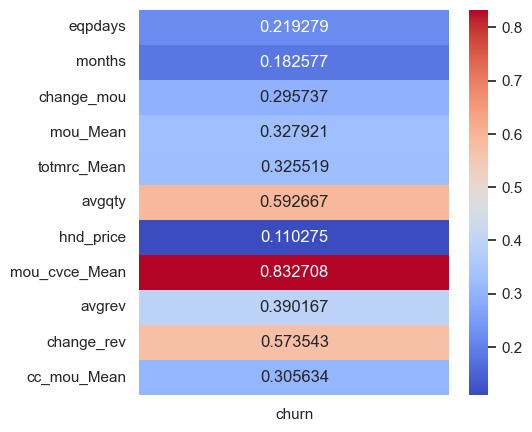

In [378]:
correlationMatrix=pd.DataFrame({"churn":relevantAttributes.values()}, index=relevantAttributes.keys())

plt.figure(figsize=(5, 5))
sns.heatmap(correlationMatrix, annot=True, fmt="g", cmap='coolwarm')

plt.show()